In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from tqdm.autonotebook import tqdm
import os
import cftime
import json
from dask import array

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20, interval='2s')
client = Client(cluster)
client

distributed.dashboard.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.48.160.10:45299
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-388d421a-6df1-11ea-81d9-0a2b65f2e791
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.48.160.10:45299 Dashboard: /user/ghall3-pangeo_tests-65pk03ig/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
gcs = gcsfs.GCSFileSystem(token='anon')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrss,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN


In [4]:
dfs = pd.read_csv('pangeo.csv')

In [5]:
# file_attrs = json.load(open('file_attrs.txt','r'))
# all_attrs = set(['_'.join([a['source_id'],a['member_id'],a['experiment_id'],a['table_id'],a['variable_id']]) for a in file_attrs])

# def want(s, m, e, t, v):
#     key = s+'_'+m+'_'+e+'_'+t+'_'+v
#     return s+'_'+m+'_'+e+'_'+t+'_'+v

# dfs = df[df[['source_id','member_id','experiment_id','table_id','variable_id']].apply(lambda x: want(*x) in all_attrs, axis=1)]

# pangeo_attrs = set(dfs[['source_id','member_id','experiment_id','table_id','variable_id']].apply(lambda x: want(*x), axis=1).values)
# manual_attrs = [a for a in all_attrs if a not in pangeo_attrs]
# json.dump(list(pangeo_attrs), open('pangeo_loads.txt', 'w'))
# json.dump(list(manual_attrs), open('manual_loads.txt', 'w'))

# dfs.to_csv('pangeo_loads.csv')

In [6]:
def load_srch_data(df, source_id, expt_id):

    uri = df[(df.source_id == source_id) &
                         (df.experiment_id == expt_id)].zstore.values[0]
    
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

def load_data(series):
    ds = xr.open_zarr(gcs.get_mapper(series.zstore), consolidated=True)
    return ds

def get_dims(ds):
    ds_coords = [l for l in list(ds.coords.keys()) if 'bnds' not in l and 'vert' not in l]
    dims = [[l for l in ds_coords if 'lat' in l][0], [l for l in ds_coords if 'lon' in l][0]]
    lon = ds.coords.get(dims[0])
    lat = ds.coords.get(dims[1])
    return lat, lon

def get_area(ds, df):
    var = ds.get(ds.variable_id)
    realm = ds.table_id[0].lower()
    area = None
    lat, lon = get_dims(ds)
    dims = [lat.name, lon.name]

    df_area = df.query("variable_id == 'areacell"+realm+"' & source_id == '"+ds.source_id+"'")
    if len(df_area.zstore.values) == 0:
        if len(lat) > 1000:
            area = lat
            dims = ["ncells"]
            total_area = lat.sum()
        time, lon, area = np.meshgrid(ds.time, lon, np.cos(lat), indexing='ij')
        total_area = area[0,:,:].sum()
    else:
        ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
        area = ds_area.get("areacell"+realm)
        total_area = area.sum(dims)

    return area, dims, total_area

def avg_var(ds, df):
    area, dims, total_area = get_area(ds, df)
    var = ds.get(ds.variable_id)
    
    ta_timeseries = (var * area).sum(dim=dims) / total_area
    
    if isinstance(ta_timeseries, type(None)):
        print('failed')
    return ta_timeseries



In [7]:
results = {}

In [12]:
for num in tqdm(list(range(len(dfs)))):
    s = dfs.iloc[num]
    name = '_'.join([s.source_id, s.experiment_id, s.member_id, s.variable_id])
    if name in below_avg[:,0]:
        ds = load_data(s)
        break
    
    if s.table_id == 'Omon' or name + '.npy' in os.listdir('data') or 'EC-Earth3' in s.source_id:
        continue
        
    print(str(num),':',name)
    
    ds = load_data(s)
    if ds.experiment_id == 'piControl' or ds.experiment_id == '1pctCO2':
        ds = ds.sel(time=slice(ds.time[0], ds.time[min([1799, len(ds.time)-1])]))
    elif len(ds.time) > 2400:
        ds = ds.sel(time=slice(ds.time[0], ds.time[2399]))
    m = avg_var(ds, df)

    if not isinstance(m, type(None)):
        np.save('data/'+name, np.array([m.values[:], np.array([np.datetime64(t) for t in m.time.values])[:]]))

353 : GISS-E2-1-G_piControl_r1i1p1f3_ts
356 : GISS-E2-1-G_piControl_r2i1p1f1_ts
359 : GISS-E2-2-G_1pctCO2_r1i1p1f1_ts
361 : GISS-E2-2-G_piControl_r1i1p1f1_ts
364 : CESM2-FV2_piControl_r1i1p1f1_ts
369 : CESM2-WACCM-FV2_piControl_r1i1p1f1_ts
374 : CESM2-WACCM_1pctCO2_r1i1p1f1_ts
377 : CESM2-WACCM_abrupt-4xCO2_r1i1p1f1_ts
380 : CESM2-WACCM_piControl_r1i1p1f1_ts
385 : CESM2_1pctCO2_r1i1p1f1_ts
388 : CESM2_abrupt-4xCO2_r1i1p1f1_ts


distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.161.38:42049', name: 3, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.161.38:42049
distributed.core - INFO - Starting established connection


391 : CESM2_piControl_r1i1p1f1_ts
396 : NorCPM1_1pctCO2_r1i1p1f1_ts
399 : NorCPM1_abrupt-4xCO2_r1i1p1f1_ts
401 : NorCPM1_piControl_r1i1p1f1_ts
402 : NorCPM1_piControl_r2i1p1f1_ts


distributed.scheduler - INFO - Retire worker names (0,)
distributed.scheduler - INFO - Retire workers {<Worker 'tcp://10.48.161.32:42461', name: 0, memory: 3, processing: 0>}
distributed.scheduler - INFO - Moving 3 keys to other workers
distributed.scheduler - INFO - Closing worker tcp://10.48.161.32:42461
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.48.161.32:42461', name: 0, memory: 3, processing: 0>
distributed.core - INFO - Removing comms to tcp://10.48.161.32:42461
distributed.deploy.adaptive - INFO - Retiring workers [0]


403 : NorCPM1_piControl_r3i1p1f1_ts
404 : NorESM2-LM_abrupt-4xCO2_r1i1p1f1_ts
405 : NorESM2-MM_1pctCO2_r1i1p1f1_ts
406 : NorESM2-MM_abrupt-4xCO2_r1i1p1f1_ts
407 : GFDL-CM4_piControl_r1i1p1f1_ts
411 : GFDL-ESM4_piControl_r1i1p1f1_ts


distributed.scheduler - INFO - Register worker <Worker 'tcp://10.48.161.39:32819', name: 4, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.48.161.39:32819
distributed.core - INFO - Starting established connection


416 : NESM3_1pctCO2_r1i1p1f1_rlut


distributed.scheduler - INFO - Retire worker names (4,)
distributed.scheduler - INFO - Retire workers {<Worker 'tcp://10.48.161.39:32819', name: 4, memory: 0, processing: 1>}
distributed.scheduler - INFO - Closing worker tcp://10.48.161.39:32819
distributed.scheduler - INFO - Remove worker <Worker 'tcp://10.48.161.39:32819', name: 4, memory: 0, processing: 1>
distributed.core - INFO - Removing comms to tcp://10.48.161.39:32819
distributed.deploy.adaptive - INFO - Retiring workers [4]


417 : NESM3_1pctCO2_r1i1p1f1_rsdt
418 : NESM3_1pctCO2_r1i1p1f1_rsut
419 : NESM3_1pctCO2_r1i1p1f1_ts
422 : NESM3_abrupt-4xCO2_r1i1p1f1_rlut
423 : NESM3_abrupt-4xCO2_r1i1p1f1_rsdt
424 : NESM3_abrupt-4xCO2_r1i1p1f1_rsut
425 : NESM3_abrupt-4xCO2_r1i1p1f1_ts
428 : NESM3_piControl_r1i1p1f1_ts


/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [55]:
below_avg = np.array([n for n in ns if np.mean(n[1][0]) < 200])

array(['MPI-ESM1-2-HR_1pctCO2_r1i1p1f1_ts.npy',
       'MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_ts.npy',
       'NorCPM1_1pctCO2_r1i1p1f1_ts.npy'], dtype=object)

Plot 30-year moving average $\Delta T$  for 1pctCO2 runs
=======

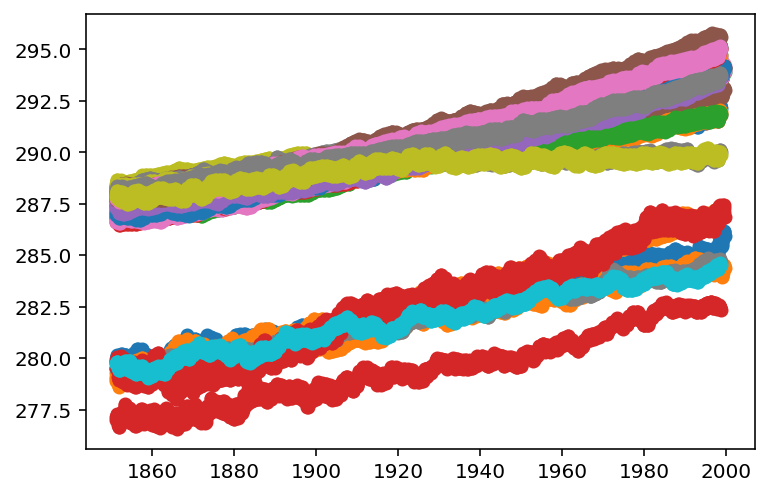

In [137]:
ns = np.array([[f, np.load('data/'+f, allow_pickle = True)] for f in os.listdir('data') if "1pctCO2" in f and '_ts.npy' in f])
below_ts = np.array([n for n in ns if np.mean(n[1][0]) < 200])
dates = [pd.to_datetime(n[1], errors='coerce') for n in ns[:,1]][0]
plt.figure("1pctCO2 runs")
for f, n in ns:
    if not isinstance(n[1,0], type(int)) and f not in below_ts[:,0]:
        w = 30
        plt.plot_date(dates[int(w/2)-1:int(len(n[0])-w/2)],
                      moving_average(n[0], w),
                      xdate=True)

In [ ]:
def percentiles(ds, df):
    Area = get_area(ds, df)
    Var = ds.get(ds.variable_id)
    
    percentiles = []
    
    for t in range(len(Var.time)):
        area = Area[t]
        var = Var[t]
        time = Var.time[t]
        
        weights = np.reshape(area.data, (np.prod(np.shape(var)),1))
        vals = np.reshape(var.data, (np.prod(np.shape(var)),1))
        weights = np.array(weights[~np.isnan(vals)])
        vals = np.array(vals[~np.isnan(vals)])

        idx = np.argsort(vals)
        vals = np.take_along_axis(vals, idx, axis=0)
        sorted_weights = np.array(np.take_along_axis(weights, idx, axis=0))
        total = np.nansum(weights)

        i = 0
        low = 0
        N = len(weights)
        pcts = np.array([0.05, 0.17, 0.5, 0.83, 0.95])
        pct_vals = []
        for j in range(0,len(vals)):
            low = low + sorted_weights[j]
            high = low + sorted_weights[min(j+1,N)]
            # If the cumulative weights are nearest the next percentile
            # Then mark down the value
            if low/total < pcts[i] and high/total >= pcts[i]:
                pct_vals += [[pcts[i], vals[j]]]
                if i == np.shape(pcts)[0] - 1:
                    break
                i = i + 1
                
        percentiles += [time, pct_vals]
    
    return percentiles


In [78]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w    